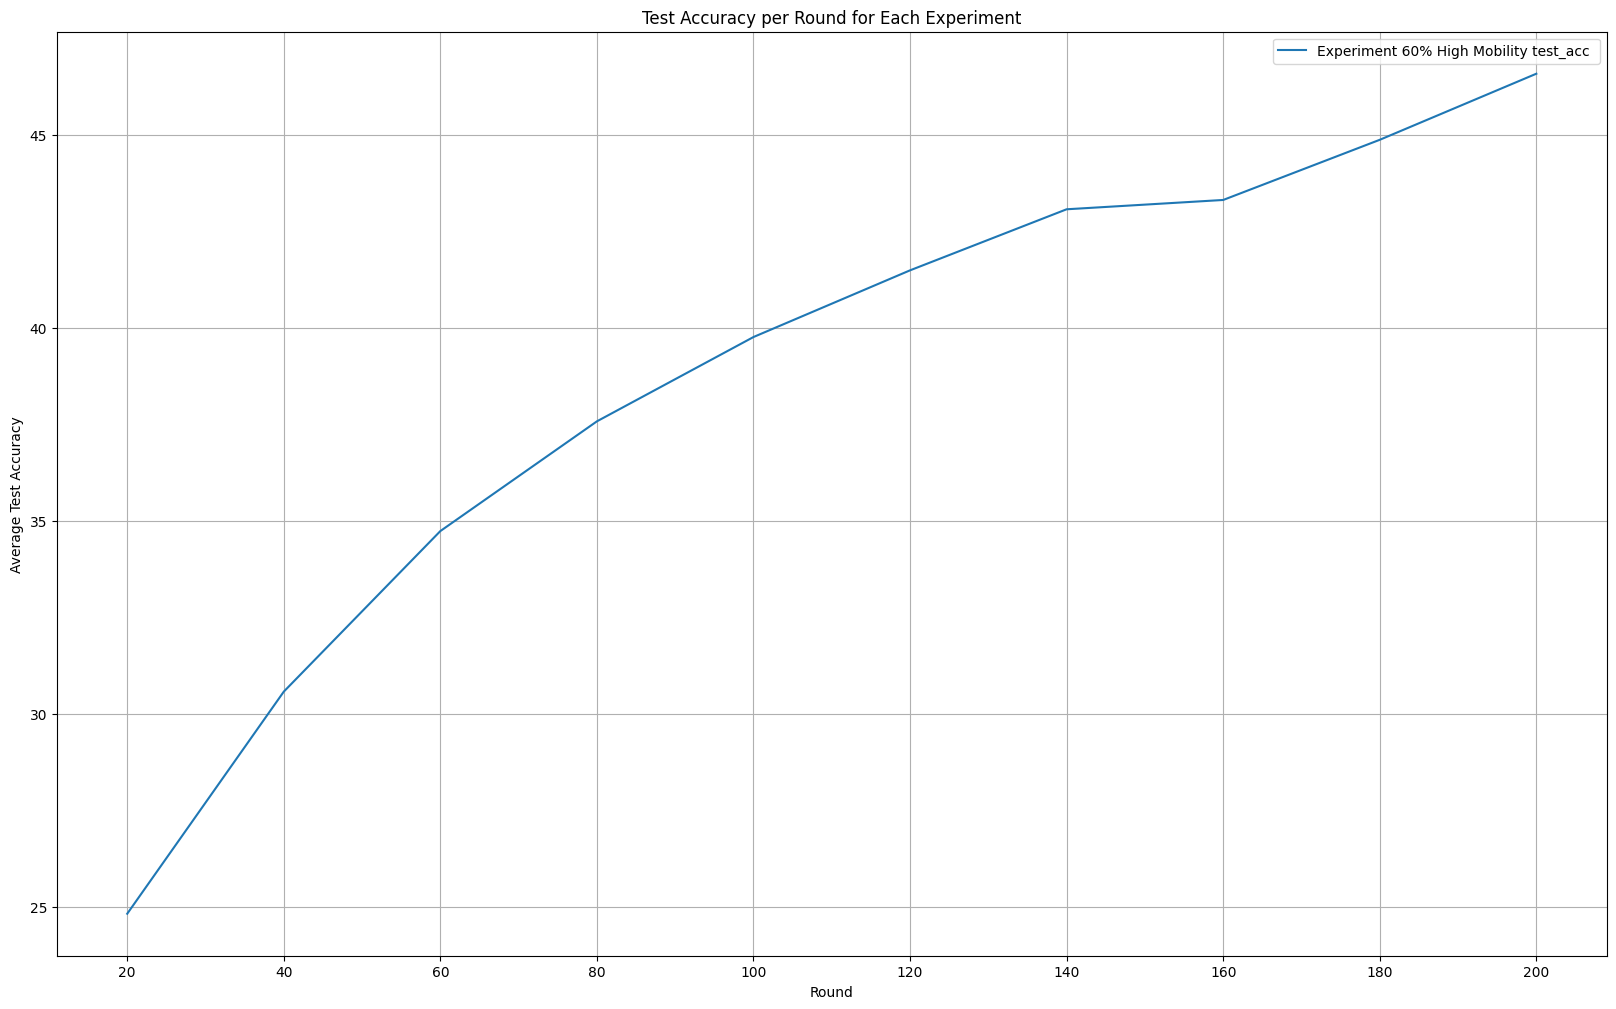

In [7]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt    
from collections import defaultdict


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])

num_nodes = 48
# rounds_cutoff = float('inf')
rounds_cutoff = 200
experiments = {
    # 0.0: ".saved_experiments/preliminary/2024-05-30T23:05-dynamic_48_0_0.txt/machine0",
    # 0.05: ".saved_experiments/preliminary/2024-05-30T23:08-dynamic_48_0_05.txt/machine0",
    # 0.2: ".saved_experiments/45-complete/2024-05-30T19:57-dynamic_48_0_2.txt/machine0",
    # 0.4: ".saved_experiments/45-complete/2024-05-30T20:33-dynamic_48_0_4.txt/machine0",
    0.6: ".saved_experiments/preliminary/2024-05-30T23:10-dynamic_48_0_6.txt/machine0",
    # 0.8: ".saved_experiments/45-complete/2024-05-30T04:07-dynamic_48_0_8.txt/machine0",
    # 1.0: ".saved_experiments/45-complete/2024-05-30T21:10-dynamic_48_1_0.txt/machine0",
}
experiment_names = {
    # 0.0: "0% High Mobility",
    # 0.05: "5% High Mobility",
    # 0.2: "20% High Mobility",
    # 0.4: "40% High Mobility",
    0.6: "60% High Mobility",
    # 0.8: "80% High Mobility",
    # 1.0: "100% High Mobility",
}
data = {}

for experiment, dir in experiments.items():
    data[experiment] = {}
    for i in range(num_nodes):
        file_path = os.path.join(dir, f"{i}_results.json")
        if os.path.exists(file_path):
            with open(file_path, "r") as file:
                content = json.load(file)

                for statistic, rounds in content.items():
                    if statistic not in data[experiment]:
                        data[experiment][statistic] = {}

                    for round, value in rounds.items():
                        if int(round) > rounds_cutoff:
                            continue

                        if round not in data[experiment][statistic]:
                            data[experiment][statistic][round] = []
                        data[experiment][statistic][round].append(value)


statistics = ["test_acc"]
averages = {}
high_mobility_averages = defaultdict(lambda: defaultdict(dict))
low_mobility_averages = defaultdict(lambda: defaultdict(dict))
for experiment in data:
    averages[experiment] = {}
    for statistic in statistics:
        if statistic not in averages[experiment]:
            averages[experiment][statistic] = {}

        for round, values in data[experiment][statistic].items():
            averages[experiment][statistic][round] = np.mean(values)

            if round == "10":
                print(values)
                print(len(values))

            high_mobility_proportion = experiment
            low_mobility_proportion = 1 - experiment
            high_mobility_averages[experiment][statistic][round] = average_of_first_percent(values, high_mobility_proportion)
            low_mobility_averages[experiment][statistic][round] = average_of_last_percent(values, low_mobility_proportion)

plt.figure(figsize=(20, 12))
def plot_averages(experiment_names, averages, extra_info=""):
    for experiment, statistics_dict in averages.items():
        for statistic in statistics:
            rounds, acc_values = zip(*averages[experiment][statistic].items())
            plt.plot(rounds, acc_values, label=f"Experiment {experiment_names[experiment]} {statistic} {extra_info}")

plot_averages(experiment_names, averages)

plt.xlabel("Round")
plt.ylabel("Average Test Accuracy")
plt.title("Test Accuracy per Round for Each Experiment")
plt.legend()
plt.grid(True)
plt.show()


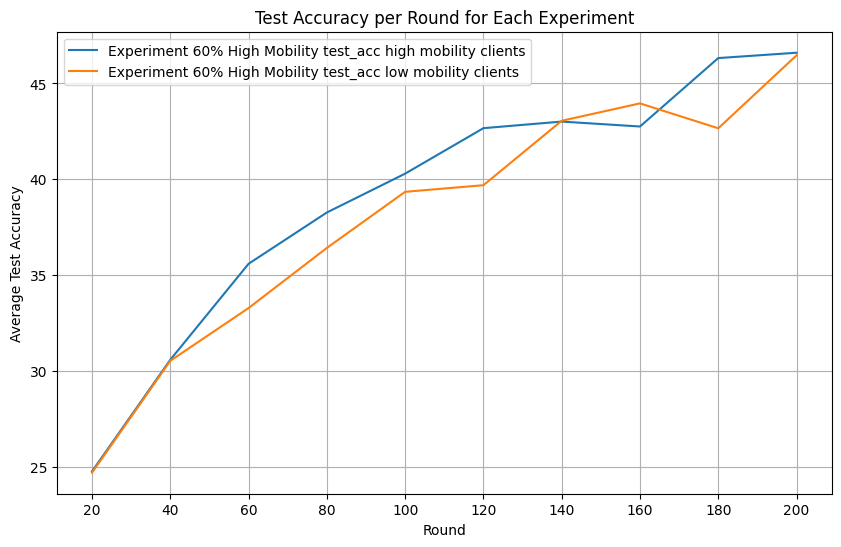

In [8]:
plt.figure(figsize=(10, 6))

plot_averages(experiment_names, high_mobility_averages, 'high mobility clients')
plot_averages(experiment_names, low_mobility_averages, 'low mobility clients')

plt.xlabel("Round")
plt.ylabel("Average Test Accuracy")
plt.title("Test Accuracy per Round for Each Experiment")
plt.legend()
plt.grid(True)
plt.show()
